In [1]:
# Yernar Shambayev, DL-2
# 1. Возьмите англо-русскую пару фраз (https://www.manythings.org/anki/)
# 2. Обучите на них seq2seq по аналогии с занятием. Оцените полученное качество
# 3. Попробуйте добавить +1 рекуррентный в encoder и decoder
# 4. Попробуйте заменить GRU ячейки на lstm-ячейки
# Оцените качество во всех случаях

from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"([,\'])", r"", s)
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('rus.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[0:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=n_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.n_layers*1, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=n_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [8]:
class EncoderLstmRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderLstmRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=n_layers)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        return output, (hidden, cell)

    def initHidden(self):
        return [torch.zeros(self.n_layers*1, 1, self.hidden_size, device=device),
                torch.zeros(self.n_layers*1, 1, self.hidden_size, device=device)]

class DecoderLstmRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderLstmRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=n_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        output = self.embedding(input).view(1, 1, -1)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        output = self.softmax(self.out(output.squeeze(0)))
        return output, (hidden, cell)

    def initHidden(self):
        return [torch.zeros(self.n_layers*1, 1, self.hidden_size, device=device),
                torch.zeros(self.n_layers*1, 1, self.hidden_size, device=device)]

In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [10]:
teacher_forcing_ratio = 0.5

def train(model_name, input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    if model_name == 'gru':
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
    else: # lstm
        for ei in range(input_length):
            encoder_output, (encoder_hidden[0], encoder_hidden[1]) = encoder(
                input_tensor[ei].unsqueeze(0), encoder_hidden[0], encoder_hidden[1])
            encoder_outputs[ei] = encoder_output.squeeze()

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            if model_name == 'gru':
                decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            else:
                decoder_output, (decoder_hidden[0], decoder_hidden[1]) = decoder(
                decoder_input, decoder_hidden[0], decoder_hidden[1])

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if model_name == 'gru':
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            else:
                decoder_output, (decoder_hidden[0], decoder_hidden[1]) = decoder(
                    decoder_input, decoder_hidden[0], decoder_hidden[1])
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [11]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [12]:
def trainIters(model_name, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(model_name, input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [14]:
def evaluate(model_name, encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        if model_name == 'gru':
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(
                    input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]
        else:  # lstm
            for ei in range(input_length):
                encoder_output, (encoder_hidden[0], encoder_hidden[1]) = encoder(
                    input_tensor[ei].unsqueeze(0), encoder_hidden[0], encoder_hidden[1])
                encoder_outputs[ei] = encoder_output.squeeze()

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            if model_name == 'gru':
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            else:
                decoder_output, (decoder_hidden[0], decoder_hidden[1]) = decoder(
                    decoder_input, decoder_hidden[0], decoder_hidden[1])

            topv, topi = decoder_output.data.topk(1)

            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [15]:
def evaluateRandomly(model_name, encoder, decoder, n=10):
    lucky = 0
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(model_name, encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)

        if output_sentence[0:len(pair[1])] == pair[1]:
            lucky += 1
        print('')

    print(f'Точность: {lucky*100/n} %')

In [16]:
input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 380911 sentence pairs
Trimmed to 4294 sentence pairs
Counting words...
Counted words:
rus 3837
eng 2086
['он гордится тем что он музыкант .', 'he is proud of being a musician .']


0m 46s (- 10m 46s) (5000 6%) 3.1075
1m 29s (- 9m 40s) (10000 13%) 2.4697
2m 12s (- 8m 49s) (15000 20%) 2.0154
2m 57s (- 8m 7s) (20000 26%) 1.6116
3m 41s (- 7m 22s) (25000 33%) 1.2675
4m 25s (- 6m 37s) (30000 40%) 0.9779
5m 9s (- 5m 53s) (35000 46%) 0.7182
5m 53s (- 5m 9s) (40000 53%) 0.5783
6m 37s (- 4m 25s) (45000 60%) 0.3884
7m 21s (- 3m 40s) (50000 66%) 0.2775
8m 5s (- 2m 56s) (55000 73%) 0.2085
8m 50s (- 2m 12s) (60000 80%) 0.1436
9m 34s (- 1m 28s) (65000 86%) 0.1103
10m 19s (- 0m 44s) (70000 93%) 0.0836
11m 3s (- 0m 0s) (75000 100%) 0.0747
> я слушаю радио .
= i am listening to the radio .
< i am listening to the radio . <EOS>

> он устал от чрезмернои работы .
= he is tired from overwork .
< he is tired from overwork . <EOS>

> они очень важные люди .
= they are very important people .
< they are very important people . <EOS>

> он страдает от головнои боли .
= he is suffering from a headache .
< he is suffering from a headache . <EOS>

> я весьма впечатлен .
= i am greatly impre

<Figure size 432x288 with 0 Axes>

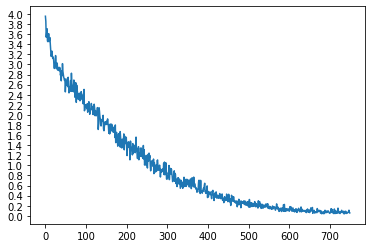

In [17]:
hidden_size = 256
# 2. Обучите на них seq2seq по аналогии с занятием. Оцените полученное качество
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters('gru', encoder1, decoder1, 75000, print_every=5000)
evaluateRandomly('gru', encoder1, decoder1)

1m 0s (- 14m 11s) (5000 6%) 3.1233
1m 57s (- 12m 41s) (10000 13%) 2.6323
2m 53s (- 11m 35s) (15000 20%) 2.2328
3m 50s (- 10m 34s) (20000 26%) 1.8395
4m 48s (- 9m 36s) (25000 33%) 1.4745
5m 45s (- 8m 38s) (30000 40%) 1.1628
6m 44s (- 7m 42s) (35000 46%) 0.8852
7m 43s (- 6m 45s) (40000 53%) 0.6624
8m 41s (- 5m 47s) (45000 60%) 0.4817
9m 38s (- 4m 49s) (50000 66%) 0.3446
10m 36s (- 3m 51s) (55000 73%) 0.2447
11m 34s (- 2m 53s) (60000 80%) 0.1783
12m 32s (- 1m 55s) (65000 86%) 0.1208
13m 30s (- 0m 57s) (70000 93%) 0.0913
14m 28s (- 0m 0s) (75000 100%) 0.0707
> они обдумывают что делать дальше .
= they are deliberating what to do next .
< they are deliberating what to do next . <EOS>

> мы в следующем месяце переезжаем .
= we are moving next month .
< we are moving next month . <EOS>

> он учится чтобы стать священником .
= he is studying to be a minister .
< he is studying to be a minister . <EOS>

> он читает у себя в комнате книгу .
= he is reading a book in his room .
< he is reading a 

<Figure size 432x288 with 0 Axes>

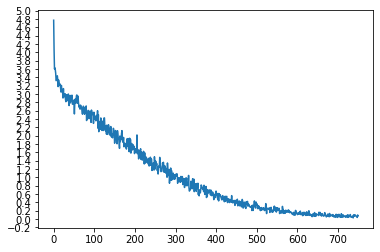

In [18]:
# 3. Попробуйте добавить +1 рекуррентный в encoder и decoder
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, n_layers=2).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words, n_layers=2).to(device)
trainIters('gru', encoder1, decoder1, 75000, print_every=5000)
evaluateRandomly('gru', encoder1, decoder1)

0m 48s (- 11m 24s) (5000 6%) 3.2621
1m 33s (- 10m 5s) (10000 13%) 2.7136
2m 17s (- 9m 11s) (15000 20%) 2.4515
3m 2s (- 8m 23s) (20000 26%) 2.1396
3m 48s (- 7m 37s) (25000 33%) 1.8233
4m 35s (- 6m 52s) (30000 40%) 1.5387
5m 22s (- 6m 8s) (35000 46%) 1.2764
6m 10s (- 5m 23s) (40000 53%) 1.1013
6m 59s (- 4m 39s) (45000 60%) 0.8787
7m 47s (- 3m 53s) (50000 66%) 0.6955
8m 34s (- 3m 6s) (55000 73%) 0.5743
9m 19s (- 2m 19s) (60000 80%) 0.4156
10m 5s (- 1m 33s) (65000 86%) 0.3426
10m 51s (- 0m 46s) (70000 93%) 0.2531
11m 37s (- 0m 0s) (75000 100%) 0.1871
> они прогуливаются .
= they are taking a walk .
< they are taking a walk . <EOS>

> он часто пропускает школу .
= he is often absent from school .
< he is often absent from school . <EOS>

> он учитель англииского .
= he is a teacher of english .
< he is an english teacher . <EOS>

> я не уверен .
= i am not sure .
< i am not sure . <EOS>

> я твоя а ты моя .
= i am yours and you are mine .
< i am yours and you are mine . <EOS>

> я всегда го

<Figure size 432x288 with 0 Axes>

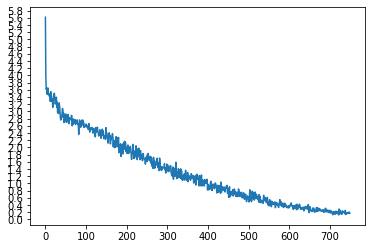

In [19]:
# 4. Попробуйте заменить GRU ячейки на lstm-ячейки
encoder1 = EncoderLstmRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderLstmRNN(hidden_size, output_lang.n_words).to(device)
trainIters('lstm', encoder1, decoder1, 75000, print_every=5000)
evaluateRandomly('lstm', encoder1, decoder1)

In [ ]:
# Вывод: LSTM хуже GRU